<a href="https://colab.research.google.com/github/minnnnppp/Section4-Project/blob/main/%08AI_10_%EB%B0%95%EB%AF%BC%EA%B2%BD_Project04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECTION04 Project: financial sentiment analysis
## 1. Data load & EDA

In [1]:
!pip install nltk
!pip install transformers

In [2]:
import os
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt

import re
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from transformers import BertTokenizer, BertForSequenceClassification, BertModel, AdamW
import nltk
from nltk.tokenize import word_tokenize

import torch
from transformers import AdamW, Adafactor, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
import random
import time
import datetime

In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/data/finsent.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
# target 분포 및 데이터 형태 확인
df['Sentiment'].value_counts(), df.shape

(neutral     3130
 positive    1852
 negative     860
 Name: Sentiment, dtype: int64, (5842, 2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


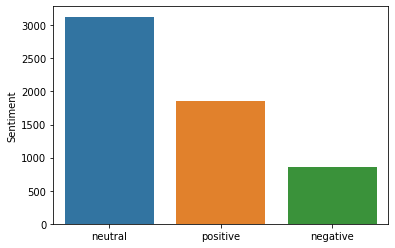

In [ ]:
# target 분포 그래프
import seaborn as sns
sns.barplot(df['Sentiment'].value_counts().index, df['Sentiment'].value_counts());

In [ ]:
# 결측치 확인 및 중복 데이터 확인
df.isna().sum(), df.duplicated().sum()

(Sentence     0
 Sentiment    0
 dtype: int64, 6)

In [5]:
# 중복 데이터 제거
df = df.drop_duplicates(keep = 'first')

## 2. 텍스트 전처리

In [6]:
# url, 기호 등의 문자들 정제하기
def cleaning(df, x):
  df[x] = df[x].str.replace(r"http\S+", " ")
  df[x] = df[x].str.replace(r"http", " ")
  df[x] = df[x].str.replace(r"@", "at")
  df[x] = df[x].str.lower()
  
  return df 

df = cleaning(df, "Sentence")
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence,Sentiment
0,the geosolutions technology will leverage bene...,positive
1,"$esi on lows, down $1.50 to $2.50 bk a real po...",negative
2,"for the last quarter of 2010 , componenta 's n...",positive
3,according to the finnish-russian chamber of co...,neutral
4,the swedish buyout firm has sold its remaining...,neutral


In [7]:
# 정규표현식
def regexx(sentence):
  sentence = re.sub(r"[^A-Za-z0-9 ]", "", sentence)

  return sentence

df['Sentence'] = df['Sentence'].apply(regexx)
df.head()

,Sentence,Sentiment
0,the geosolutions technology will leverage bene...,positive
1,esi on lows down 150 to 250 bk a real possibility,negative
2,for the last quarter of 2010 componenta s net...,positive
3,according to the finnishrussian chamber of com...,neutral
4,the swedish buyout firm has sold its remaining...,neutral


In [8]:
# 카테고리형 target: label_encoding해 label에 할당
le = LabelEncoder()
df['label'] = le.fit_transform(df['Sentiment'])
num_labels = len(le.classes_)

print("0: negative", "1: neutral", "2: positive")

0: negative 1: neutral 2: positive


## 3. Model1: LSTM
### 3-1. LSTM 텍스트 전처리

In [45]:
# train_test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(df['Sentence'], df['label'], test_size=0.15, random_state=42)

# train, val split
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.15, random_state=42)

In [46]:
# tokenizing
from keras.preprocessing.text import Tokenizer
tok = Tokenizer(num_words=8000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n ', lower=True, split=" ")

# train data tokenize
tok.fit_on_texts(X_train1)
X_train_seq = tok.texts_to_sequences(X_train1)

tok.fit_on_texts(X_val1)
X_val_seq = tok.texts_to_sequences(X_val1)

tok.fit_on_texts(X_test1)
X_test_seq = tok.texts_to_sequences(X_test1)

In [47]:
# max length 구하기
lenl = []
for text in X_train_seq:
   x = len(text)
   lenl.append(x)

lenlv = []
for text in X_val_seq:
   x = len(text)
   lenlv.append(x)

lenlt = []
for text in X_test_seq:
   x = len(text)
   lenlt.append(x)

# 최대 토큰 길이
max(lenl), max(lenlv), max(lenlt)

(50, 46, 52)

In [48]:
# padding
max_lenn = 52
X_train_pad = pad_sequences(X_train_seq, maxlen=max_lenn)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_lenn)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_lenn)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


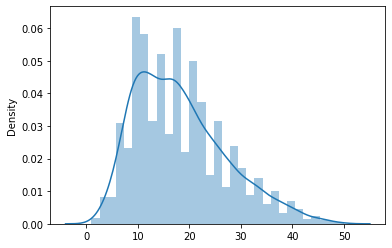

In [49]:
# 토큰 길이 분포 확인: train data
sns.distplot([len(text) for text in X_train_seq]);

In [50]:
# target 데이터 전처리
y_train1 = np.array(y_train1)
y_val1 = np.array(y_val1)
y_test1 = np.array(y_test1)

In [51]:
np.unique(y_train1)

array([0, 1, 2])

### 3-2. LSTM Model 학습

In [52]:
# model training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Dropout, LSTM

total_cnt = len(tok.word_index)
vocab_size = len(tok.word_index) + 1

modell = Sequential()
modell.add(Embedding(vocab_size, 64, input_length = max_lenn))
modell.add(Conv1D(32, 5, activation='relu'))
modell.add(Conv1D(32, 5, activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(16))
modell.add(Dropout(0.2))
modell.add(Dense(3, activation='softmax'))

In [57]:
modell.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

modell.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 52, 64)            797440    
                                                                 
 conv1d (Conv1D)             (None, 48, 32)            10272     
                                                                 
 conv1d_1 (Conv1D)           (None, 44, 32)            5152      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                        

In [58]:
fit_lstm = modell.fit(X_train_pad, y_train1, epochs=50, batch_size=32)

Epoch 1/50
132/132 [==============================] - 3s 5ms/step - loss: 0.0958 - accuracy: 0.9324
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0945 - accuracy: 0.9286
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0975 - accuracy: 0.9312
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0991 - accuracy: 0.9296
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0961 - accuracy: 0.9367
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0918 - accuracy: 0.9350
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0964 - accuracy: 0.9350
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0966 - accuracy: 0.9331
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0948 - accuracy: 0.9343
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0991 - accuracy: 0.9324

### 3-3. LSTM Model 평가

In [59]:
modell.evaluate(X_test_pad, y_test1, verbose=2)

28/28 - 1s - loss: 3.9266 - accuracy: 0.5183 - 666ms/epoch - 24ms/step


[3.9266419410705566, 0.5182648301124573]

## 4. Model2: BERT
### 4-1. BERT를 위한 텍스트 전처리

In [9]:
# Tagging
bert_text = []

for i in df['Sentence']:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  bert_text.append(bert)

bert_text[10]

['[CLS] circulation revenue has increased by 5  in finland and 4  in sweden in 2008  [SEP]']

In [10]:
# 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=False)
tokens = []

for i in bert_text:
  for j in i:
    token = tokenizer.tokenize(j)
    tokens.append(token)

df['tokens'] = tokens

In [11]:
# train, test 데이터 분할
X_trainb, X_testb, y_trainb, y_testb = train_test_split(df['tokens'], df['label'], test_size=0.15, random_state=42)

In [12]:
X_trainb.shape, y_trainb.shape, X_testb.shape, y_testb.shape

((4960,), (4960,), (876,), (876,))

In [13]:
# token to id: train(패딩을 위해 하는 과정)
train_ids = []
for i in X_trainb:
  ids = tokenizer.convert_tokens_to_ids(i)
  train_ids.append(ids)

test_ids = []
for i in X_testb:
  ids = tokenizer.convert_tokens_to_ids(i)
  test_ids.append(ids)

In [14]:
len(train_ids)

4960

In [15]:
# padding
train_ids = pad_sequences(train_ids, dtype='long', truncating='post', padding='post') # train
test_ids = pad_sequences(test_ids, dtype='long', truncating='post', padding='post') # test
train_ids[10], test_ids[10]

(array([  101,  1996,  6207,  4297, 18059, 24185, 23961,  2689,  1996,
         2208,  2933,  2005,  2310, 21885,  2239,  4806,  4297,  2708,
         3237,  7332,  7367,  5178, 11144,  2056,  9317,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]),
 array([  101,  2119,  4082,  5618,  1998,  5658,  4341,  2005,  1996,
         2416,  9629,  2232,  2558,  3445,  4414,  20

In [16]:
# masking: train
masks = []

for ids in train_ids:
  ids_mask = []
  for x in ids:
    masked = float(x>0)
    ids_mask.append(masked)
  masks.append(ids_mask)

# masking: test
masks_t = []

for ids in test_ids:
  ids_maskt = []
  for x in ids:
      maskedt = float(x>0)
      ids_maskt.append(maskedt)
  masks_t.append(ids_maskt)

In [17]:
# train, val 데이터 분할
X_trainb, X_valb, y_trainb, y_valb = train_test_split(train_ids, y_trainb, test_size=0.15, random_state=42)

# mask 이름 수정
train_m = masks
test_m = masks_t

In [20]:
# test 데이터 이름 수정
X_testb = test_ids

# mask 분할: train/val
train_masks, val_masks, _, _ = train_test_split(train_m, train_m, test_size=0.15, random_state=42)

In [21]:
len(train_masks), X_trainb.shape, len(test_m), X_testb.shape

(4216, (4216, 110), 876, (876, 70))

In [22]:
# target 데이터 array 형태로 변환
y_trainb = np.array(y_trainb)
y_valb = np.array(y_valb)
y_testb = np.array(y_testb)

In [23]:
# Fine-tuning과 Tensor 데이터 구분하기
X_train_tune = X_trainb
y_train_tune = y_trainb

X_val_tune = X_valb
y_val_tune = y_valb

X_test_tensor = X_testb
y_test_tensor = y_testb
test_masks = test_m


# PyTorch 변환
X_train_tensor = torch.tensor(X_trainb)
y_train_tensor = torch.tensor(y_trainb)
train_masks = torch.tensor(train_masks)

X_val_tensor = torch.tensor(X_valb)
y_val_tensor = torch.tensor(y_valb)
validation_masks = torch.tensor(val_masks)

X_test_tensor = torch.tensor(X_test_tensor)
y_test_tensor = torch.tensor(y_test_tensor)
test_masks = torch.tensor(test_m)

In [24]:
# tensor dataset
batch_size = 32

train = TensorDataset(X_train_tensor, train_masks, y_train_tensor)
train_sampler = RandomSampler(train)

val = TensorDataset(X_val_tensor, validation_masks, y_val_tensor)
val_sampler = SequentialSampler(val)


test = TensorDataset(X_test_tensor, test_masks, y_test_tensor)
test_sampler = RandomSampler(test)

# dataloader
train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val, sampler=val_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test, sampler=test_sampler, batch_size=batch_size)

### 4-2. BERT fine-tuning

In [25]:
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

In [26]:
# BERTTokenize를 위해 list 형태로 변환
texts = train_df["Sentence"].to_list() # Features (not-tokenized yet)
labels = train_df["label"].to_list() # Labels

In [27]:
# train, val 데이터 분할
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.15, random_state=42)

In [28]:
## tokenized
max_len = 110
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_len)
val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=max_len)

In [29]:
class Sensitive_dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = list(map(int,labels))
  
  def __getitem__(self, idx):
    item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    if self.labels:
      item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = Sensitive_dataset(train_encodings, train_labels)
val_dataset = Sensitive_dataset(val_encodings, val_labels)

In [30]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy='epoch',
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    weight_decay=0,               # strength of weight decay
    logging_dir='./log'            # directory for storing logs
)

In [31]:
# BERT 모델 생성
modelb = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

trainer = Trainer(
    model=modelb,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4216
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1320


Epoch,Training Loss,Validation Loss
1,No log,0.474539
2,No log,0.465567
3,No log,0.616948
4,0.381600,0.701968
5,0.381600,0.814698
6,0.381600,0.818546
7,0.381600,0.877679
8,0.147400,0.957429
9,0.147400,1.034356
10,0.147400,1.081597


***** Running Evaluation *****
  Num examples = 744
  Batch size = 32
***** Running Evaluation *****
  Num examples = 744
  Batch size = 32
***** Running Evaluation *****
  Num examples = 744
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 744
  Batch size = 32
***** Running Evaluation *****
  Num examples = 744
  Batch size = 32
***** Running Evaluation *****
  Num examples = 744
  Batch size = 32
***** Running Evaluation *****
  Num examples = 744
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 744
  Batch size = 32
***** Running Evaluation *****
  Num examples = 744
  Batch size = 32
***** Runni

TrainOutput(global_step=1320, training_loss=0.2286920778679125, metrics={'train_runtime': 500.0849, 'train_samples_per_second': 84.306, 'train_steps_per_second': 2.64, 'total_flos': 2383232004014400.0, 'train_loss': 0.2286920778679125, 'epoch': 10.0})

In [33]:
# device
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

1
Tesla P100-PCIE-16GB
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### 4-3. BERT 모델 학습

In [41]:
# 옵티마이저 설정
optimizer = AdamW(modelb.parameters(), lr=1e-6, eps = 1e-8)

epochs = 20

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# Learning rate decay
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [39]:
# 정확도 계산 함수
def accuracy(y_pred, y):
    pred_flattened = np.argmax(y_pred, axis=1).flatten()
    y_flattened = y.flatten()
    return np.sum(pred_flattened == y_flattened) / len(y_flattened)
    
# 시간 표시 함수
def time_elapsed(elapsed):
    # 반올림
    elapsed = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed))

In [37]:
# 랜덤시드 고정 for 재현
seed = 20
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 그래디언트 초기화
modelb.zero_grad()

In [43]:
# 본격적인 학습
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    
    # 현재 훈련 조건 표시
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('훈련중~~~~')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    modelb.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
          elapsed = time_elapsed(time.time() - t0)
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
            
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = modelb(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
            
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(modelb.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        modelb.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(time_elapsed(time.time() - t0)))        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("검증하는 중~~~")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    modelb.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
            
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
            
        # 그래디언트 계산 안함
        with torch.no_grad():     
          # Forward 수행
          outputs = modelb(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
            
          # 로스 구함
          logits = outputs[0]

          # CPU로 데이터 이동
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
            
          # 출력 로짓과 라벨을 비교하여 정확도 계산
          tmp_eval_accuracy = accuracy(logits, label_ids)
          eval_accuracy += tmp_eval_accuracy
          nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(time_elapsed(time.time() - t0)))

print("")
print("훈련 끝!")


======== Epoch 1 / 20 ========
훈련중~~~~

  Average training loss: 0.11
  Training epcoh took: 0:00:46

검증하는 중~~~
  Accuracy: 0.74
  Validation took: 0:00:03

======== Epoch 2 / 20 ========
훈련중~~~~

  Average training loss: 0.11
  Training epcoh took: 0:00:46

검증하는 중~~~
  Accuracy: 0.75
  Validation took: 0:00:03

======== Epoch 3 / 20 ========
훈련중~~~~

  Average training loss: 0.11
  Training epcoh took: 0:00:46

검증하는 중~~~
  Accuracy: 0.75
  Validation took: 0:00:03

======== Epoch 4 / 20 ========
훈련중~~~~

  Average training loss: 0.11
  Training epcoh took: 0:00:46

검증하는 중~~~
  Accuracy: 0.75
  Validation took: 0:00:03

======== Epoch 5 / 20 ========
훈련중~~~~

  Average training loss: 0.11
  Training epcoh took: 0:00:46

검증하는 중~~~
  Accuracy: 0.75
  Validation took: 0:00:03

======== Epoch 6 / 20 ========
훈련중~~~~

  Average training loss: 0.11
  Training epcoh took: 0:00:46

검증하는 중~~~
  Accuracy: 0.74
  Validation took: 0:00:03

======== Epoch 7 / 20 ========
훈련중~~~~

  Average trainin

### 4-4. BERT Model 평가

In [44]:
# test dataset evaluate
modelb.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps = 0

for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    
    
    with torch.no_grad():
        outputs = modelb(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs[0]
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    tmp_acc = accuracy(logits, label_ids)
    eval_accuracy += tmp_acc
    nb_eval_steps += 1
    
print(f"테스트 정확도 : {eval_accuracy/nb_eval_steps}")

테스트 정확도 : 0.7492559523809524


## requirements.txt

In [ ]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill=

In [ ]:
pip freeze > requirements.txt